## Synthetic Pharmacy Claims Data Analysis - Python Coding Exercise
#### Auther: Zhaohui Wang
#### Goal: The goal of this notebook is to provide EDA of the synthetic pharmacy claims data, and a baseline linear regression model to inference total invoice amount.
#### Summary: 
1. The dataset contains 1000 rows each with 13 columns (including numeric, categorical and datetime datatypes).
2. No missing or extreme values (outliers) are identified.
3. The distribution of the dependent variable peaks at 1000, it is nearly symmetric but not normal. The frequency distribution for the days of supply is almost uniform with slightly higher frequencies in the middle, the lower and the higher ranges but I would not call it multimodal. The other four categorical variables are all balanced.
4. The outcomes from EDA and association/correlation analysis indicate there is no patterns or correlations between the dependent and the independent variables in the raw dataset.
5. Two linear regression approaches were applied as examples of model training on dataset like this. Strategies for improving the model performance on real world data were discussed in the section below.  

In [1]:
import sys
from datetime import datetime

# Libraries/modules/funcitons for data preprocessing and analysis
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from scipy.stats import normaltest, shapiro, skew, kurtosis

# Libraries/modules/funcitons for regression
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import set_config
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [2]:
# user info and virtual env path
print(f"Last updated: {datetime.now()}\n"
      f"User name: {Path.home().name}\n"
      f"Environement/Shell path: {sys.executable}\n"
      #f"Working Dir: {Path.cwd()}"
      )

Last updated: 2024-11-07 12:00:44.863356
User name: zhaohuiwang
Environement/Shell path: /mnt/e/zhaohuiwang/dev/poetry-venvs/sandbox/.venv/bin/python



### Load and explore the dataset

In [3]:
# Load the data from the raw csv file saved in data directory
DATA_DIR_PATH = "../data/input/"
FILE_NAME = "synthetic_pharmacy_claims.csv"
sp_claim= pd.read_csv(
    Path(DATA_DIR_PATH)/FILE_NAME
    ) 

In [4]:
# Take a glance at the first few records
sp_claim.head(3)

,Claim_Fact_Id,Client_Id,Date_Of_Service,Person_Id,Line_Of_Business_Code,NDC,Days_Supply,Specialty_Drug_Indicator,Brand_Drug_Indicator,Diagnosis_Code_1,Diagnosis_Code_2,Diagnosis_Code_3,Total_Invoice_Amount
0,bb472d7f-629b-40e9-abcc-b14d5dab1b90,D,1/28/2022,19431,LOB1,73582267455,37,Y,Y,47937,20902,86162,1480.55
1,c9bead79-c556-401c-9e8c-767b64293cad,D,5/27/2021,33243,LOB2,43029575634,45,Y,N,75924,56287,29682,562.01
2,6a98ab56-f773-4036-aba6-c86e19af9681,C,8/16/2023,48684,LOB2,57939103623,69,N,Y,24673,84292,71573,168.80


In [5]:
# Display information about the dataset
print(sp_claim.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Claim_Fact_Id             1000 non-null   object 
 1   Client_Id                 1000 non-null   object 
 2   Date_Of_Service           1000 non-null   object 
 3   Person_Id                 1000 non-null   int64  
 4   Line_Of_Business_Code     1000 non-null   object 
 5   NDC                       1000 non-null   int64  
 6   Days_Supply               1000 non-null   int64  
 7   Specialty_Drug_Indicator  1000 non-null   object 
 8   Brand_Drug_Indicator      1000 non-null   object 
 9   Diagnosis_Code_1          1000 non-null   int64  
 10  Diagnosis_Code_2          1000 non-null   int64  
 11  Diagnosis_Code_3          1000 non-null   int64  
 12  Total_Invoice_Amount      1000 non-null   float64
dtypes: float64(1), int64(6), object(6)
memory usage: 101.7+ KB
None


In [6]:
# correlation matrix -  the raw numeric variables before any preprocessing
# pandas.DataFrame.select_dtypes(include/exclude='category'|'number'|...,)
corr_matrix = sp_claim.select_dtypes(include='number').corr() # Pearsons by default
corr_matrix.style.background_gradient(cmap='coolwarm', axis=None)

,Person_Id,NDC,Days_Supply,Diagnosis_Code_1,Diagnosis_Code_2,Diagnosis_Code_3,Total_Invoice_Amount
Person_Id,1.000000,-0.002935,0.001761,0.023664,0.044196,-0.017780,0.017207
NDC,-0.002935,1.000000,-0.000819,-0.091179,-0.027977,0.032557,0.005567
Days_Supply,0.001761,-0.000819,1.000000,0.005786,0.032835,-0.008280,0.035586
Diagnosis_Code_1,0.023664,-0.091179,0.005786,1.000000,0.010631,-0.034100,0.002953
Diagnosis_Code_2,0.044196,-0.027977,0.032835,0.010631,1.000000,0.009575,0.009830
Diagnosis_Code_3,-0.017780,0.032557,-0.008280,-0.034100,0.009575,1.000000,0.036316
Total_Invoice_Amount,0.017207,0.005567,0.035586,0.002953,0.009830,0.036316,1.000000


A few feature varaibles require more attention: 
- Diagnosis codes are alphanumeric and require a decimal after the 3rd character. This synthetic data does not have to follow the rules but it is better to convert the diagnosis codes from integers into strings.
- Similarly, the National Drug Code (NDC) and Client_Id are better categorized as string types other than integers. Plus, there is no evidence they correlate with the target variable anyway from the above correlation coefficient values.
- Of course, the `Date_Of_Service` should be a datetime data types.


In [7]:
# Make some data type conversions
sp_claim = sp_claim.astype(
    {
        'Person_Id': str,
        'NDC': str,
        'Diagnosis_Code_1': str,
        'Diagnosis_Code_2': str,
        'Diagnosis_Code_3': str
        }
    )

sp_claim['Date_Of_Service'] = pd.to_datetime(sp_claim['Date_Of_Service'], format='%m/%d/%Y')

print(f"\nData types after conversion:\n{sp_claim.dtypes}")


Data types after conversion:
Claim_Fact_Id                       object
Client_Id                           object
Date_Of_Service             datetime64[ns]
Person_Id                           object
Line_Of_Business_Code               object
NDC                                 object
Days_Supply                          int64
Specialty_Drug_Indicator            object
Brand_Drug_Indicator                object
Diagnosis_Code_1                    object
Diagnosis_Code_2                    object
Diagnosis_Code_3                    object
Total_Invoice_Amount               float64
dtype: object


In [8]:
# Check (again after the DataFrame.info() method) for missing values
sp_claim.isnull().sum()

Claim_Fact_Id               0
Client_Id                   0
Date_Of_Service             0
Person_Id                   0
Line_Of_Business_Code       0
NDC                         0
Days_Supply                 0
Specialty_Drug_Indicator    0
Brand_Drug_Indicator        0
Diagnosis_Code_1            0
Diagnosis_Code_2            0
Diagnosis_Code_3            0
Total_Invoice_Amount        0
dtype: int64

There is no missing values in this synthetic data set. In real world data, missings are almost certain due to various reasons (completely at random, at random or not at random) and there are two options to handle missing values: The 1st options is to simply remove variable or instances with missing values (DataFrame.dropna(), only if the missings donot represent a significant portion of the dataset or that specific variable/instance contains a lot of missings and the variable is not significant), but not recommended in general. The 2nd and the better option is to perform imputation using statistical or machine learning methods. Various Pandas dataframe methods including fillna()/[ffill() | bfill()], replace(), and interpolate(method=[...]) coupled with median(), mode()[0], mean() or a constant value, are among the simple and commonly used approaches to handle missing values. `sklearn.impute` module is another resource toolbox to consider for simple ML projects. </br>
One point worth mentioning is that some algorithms like XGBoost, Naive Bayes and KNN can handle missing values well when supplied with relevant parameters.

In [9]:
# Generate descriptive statistics - uncomment the include parameter if you are only interested in the numeric columns
print('\nSummary Statistics:\n')
display(sp_claim.describe(
    include='all'
    ).transpose()
        )


Summary Statistics:



,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Claim_Fact_Id,1000,1000,9807e3ea-c320-41c2-b27f-03d1ad811d6e,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Client_Id,1000,4,A,262,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date_Of_Service,1000,NaN,NaN,NaN,2022-05-26 06:31:40.800000,2020-01-02 00:00:00,2021-03-14 12:00:00,2022-05-22 00:00:00,2023-07-21 18:00:00,2024-10-16 00:00:00,NaN
Person_Id,1000,100,97167,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Line_Of_Business_Code,1000,3,LOB2,345,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NDC,1000,1000,20613943966,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Days_Supply,1000.0,NaN,NaN,NaN,43.716,1.0,21.0,43.0,65.0,90.0,25.953283
Specialty_Drug_Indicator,1000,2,N,501,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Brand_Drug_Indicator,1000,2,N,508,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Diagnosis_Code_1,1000,996,83716,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Anomalies in this synthetic dataset: 
- The `NDC` (National Drug Code) is a unique 10-digit, 3-segment number. It is a universal product identifier for human drugs. There is no idential NDC in this dataset (freq 1) which may indicate the lack of refill records. This is uncommon.
- The `Brand_Drug_Indicator` variable is expected to have two values: brand(Yes) and generic(No). In reality nine out of 10 prescriptions filled in the U.S. are for generic drugs. On average, the cost of generics is 80-85 percent less than brand-name. So this variable should have predictor value for modeling `Total_Invoice_Amount`. 
- Similarly, the `Specialty_Drug_Indicator` variable is also expected to have two values (Yes or No). In general, specialty drugs account for only about 2% of the volume of drugs dispensed, but they also account for more than 50% of overall drug spending. This variable should be a predictor as well. Values in both indicator variables are near balanced (see the following categorical feature plots) which is unlikely to happen in real world examples.
- The three `Diagnosis_Code_[1|2|3]` variables are expected to contain alphanumeric characters, not just integers. A higher level of frequency is expected than what are observed in this synthetic dataset. 

In [10]:
# Check total number of claims per person - no alert here
sp_claim.Person_Id.value_counts(sort=True).describe().astype(int)

count    100
mean      10
std        3
min        3
25%        8
50%       10
75%       13
max       18
Name: count, dtype: int64

The statistics (distribution) of total claims per person looks OK. 

### Plot and analyze variables in the dataset
As the modeling goal is to predict `Total_Invoice_Amt` (the dependent variable) with a subset of predictors (independent variables) in the data set. We first need to perform EDA on the target and possible predictor candidates focusing on their distributions, associations(pairwise dependencies) and correlations. `Claim_Fact_Id`, `Diagnosis_Code_[1|2|3]`, `NDC` are documentation codes and their values are almost distinct from one another in this dataset. We can exclude them from the first round of feature analysis and modeling effort unless there is ways to map them into categories with distinct characteristics (with real world data) but it is impractical for a synthetic dataset like this. Similar, `Person_ID` can be excluded as well. In the real world, variables with demographic information are valuable for models.</br>
`Date_Of_Service` may contain some trend and seasonal pattern (almost certain in real world data) which are helpful for predicting the target but it does not seem to fit into this ~ 2 hours exercise. Similar, demographic data are informative and should not be overlooked in healthcare/pharmacy analysis/modeling. We will put these in the future.   

In [11]:
# List of numerical features
numerical_features = ['Days_Supply', 'Total_Invoice_Amount']

# List of categorical features
categorical_features = ['Client_Id', 'Line_Of_Business_Code', 'Specialty_Drug_Indicator', 'Brand_Drug_Indicator']
color_palette = ['#94a3b8', '#64748b', '#475569', '#334155']

# Make a shallow copy of the data so the EDA/plotting code snippet can be reused without much renaming
dta = sp_claim.copy()

##### Plot for each numerical feature - statistics, distribution, outliers

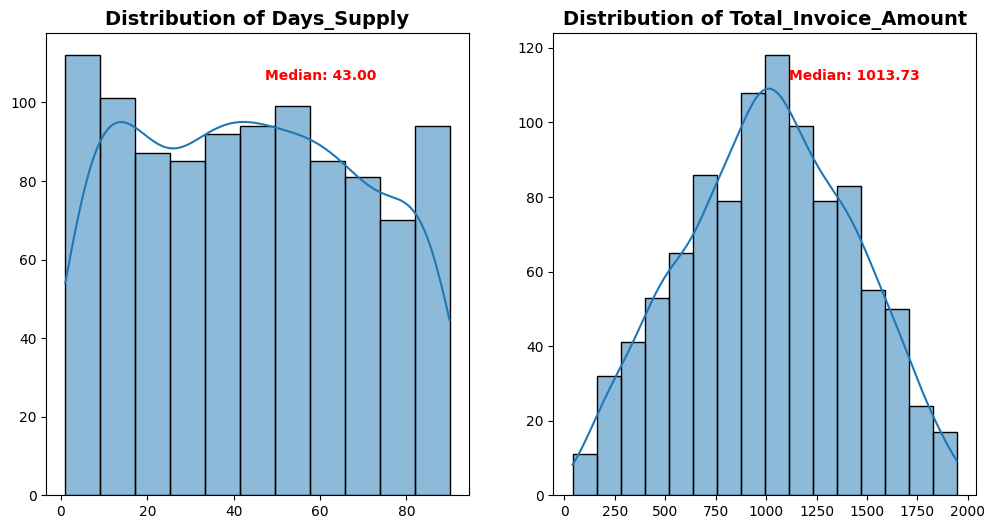

In [12]:
# Creates a figure and subplots (one axs object) based on the number of features to be plotted
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for i, feature in enumerate(numerical_features):
    ax=axs[i]
    sns.histplot(ax=ax, data=dta, x=feature, kde=True)
    
    # Annotate the medians (same as the 50% percentile from the output by the describe method in Pandas) onto the plot after executing each hisplot function
    median_v = dta[feature].median()
    ax.text(median_v*1.1, ax.get_ylim()[1] * 0.9,
            f"Median: {median_v:.2f}", 
         color='red', fontsize=10, fontweight='bold')
    
    ax.set_title(f"Distribution of {numerical_features[i]}", loc='center', fontsize=14, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')

# Adjust and show
plt.show()

In [13]:
# Shapiro-Wilk test for normality
print(shapiro(dta['Total_Invoice_Amount']))
# normality test based on D'Agostino and Pearson's test
print(normaltest(dta['Total_Invoice_Amount']))
# Skeness test for the lack of symmetry. low or approximately symmetric: (-0.5, 0.5); moderately skewed: (-1, -0.5) U (0.5, 1); Highly skewed: < -1 or > 1.
print(f"Skeness: {skew(dta['Total_Invoice_Amount'])}")
# Optional. Kurtosis measure whether the data are heavy-tailed or light-tailed relative to a normal distribution
print(f"Kurtosis: {kurtosis(dta['Total_Invoice_Amount'])}")

ShapiroResult(statistic=np.float64(0.9902634740070855), pvalue=np.float64(3.4857367374564746e-06))
NormaltestResult(statistic=np.float64(40.131557497611254), pvalue=np.float64(1.9299364755277513e-09))
Skeness: -0.05692534185464266
Kurtosis: -0.6490892367244534


By simply looking at this histogram, we can tell that `Total_Invoice_Amount` exhibits a 'bell' curved shape but the normality tests failed to support a normal distribution. The kurtosis is negative which indicates light tails/higher peak and lack of outliers. The Skewness value shows that the lack of symmetry is invalid. Also, there is no evidence for outliers in the histogram above, the boxplot below nor in the following pair scatter plots. Ther are other methods to identify outliers including boxplot, interquartile range (IQR) and Z-score but at this point it is safe to conclude no outliers in `Total_Invoice_Amount`. </br>
When it comes to real word data, outliers of global, local, univariate and multivariate scope and/or nature do exist. Outliers can significantly impact summary statistics, potentially leading to misleading conclusions if not properly addressed. Outliers can also pull the regression line towards them, resulting in biased estimate and model fit. On the other hand, if not from any incorrect recording during data collection, outliers may represent valuable information about rare events or anomalies that deserve special attention and investigation. Options to handle outliers include trimming/removal (cautious), flooring/capping(quantile), imputation(mean/median), and transformation (log, power or Box-Cox). Similar to `sklearn.impute` module for missing values, `sklearn.preprocessing` module provides a variety of data preprocessing tools to choose from. 

<Axes: ylabel='Total_Invoice_Amount'>

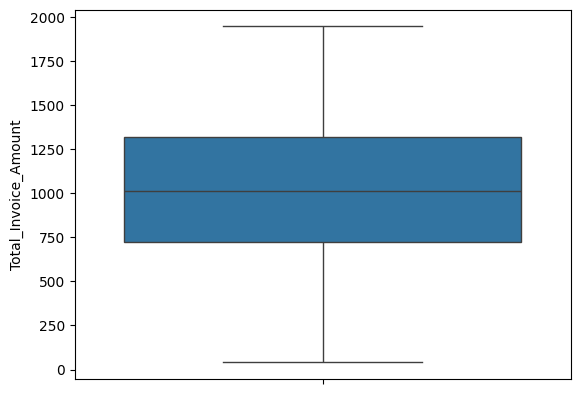

In [14]:
# Box Plot of the target variable - check for outliers
sns.boxplot(dta['Total_Invoice_Amount'])

##### Plot for each categorical feature - statistics, distribution, balance

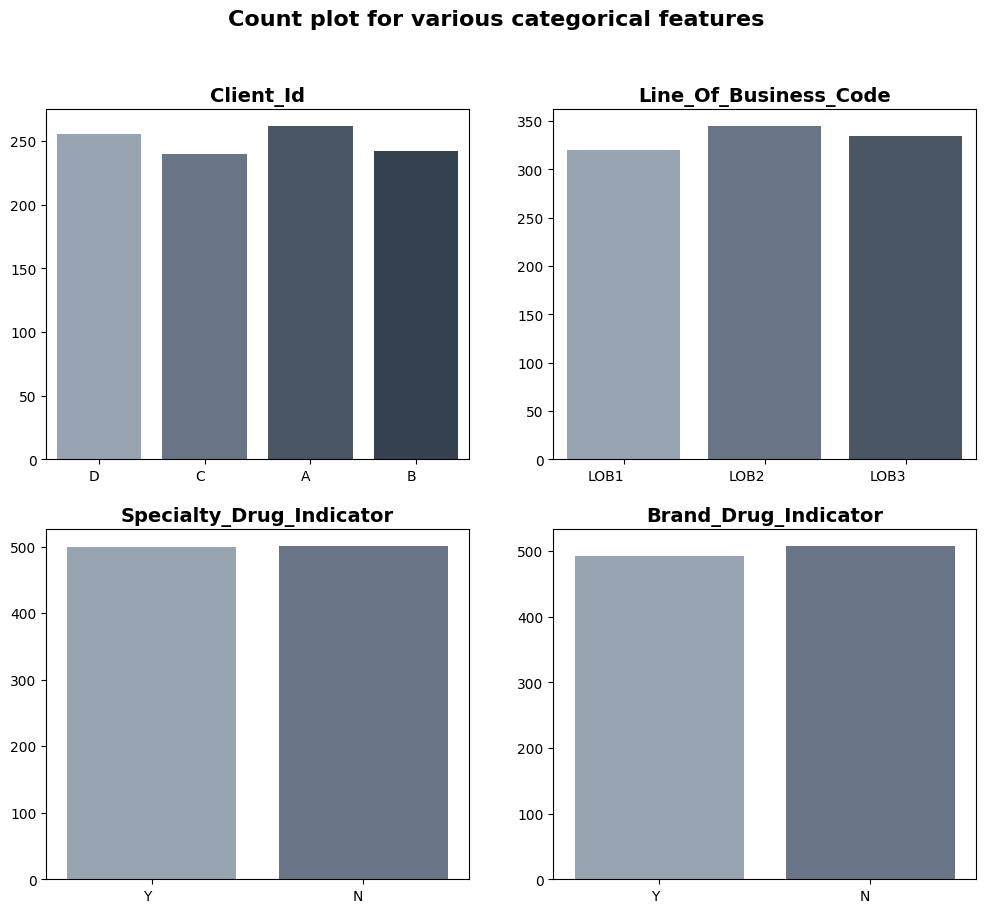

In [15]:
# Creates a figure and subplots (one axs object) based on the number of features to be plotted
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
# 2D array to 1D to make axes indexing easier
axs = axs.flatten()
fig.suptitle('Count plot for various categorical features',
             fontsize=16, fontweight='bold')
 
for i, feature in enumerate(categorical_features):
    ax=axs[i]
    sns.countplot(ax=axs[i], data=dta, x=feature, palette=color_palette)
    
    ax.set_title(categorical_features[i], loc='center',
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels(ax.get_xticklabels(), 
                       # rotation=30, 
                       ha='right', fontsize=10)

# Adjust and show
plt.show()

These four categorical variables seem to be balanced and no further preprocessing is necessary. When it come to the imbalance issue in real word data, imbalanced-learn library (replies on sklearn) with API tools is the first resource to look at. Depending on which modeling approach to choose, some ML algorithms like XGBoost and AdaBoost can be effective for imbalanced dataset so data imbalance wont be any concern.

### Explore potential features for model building

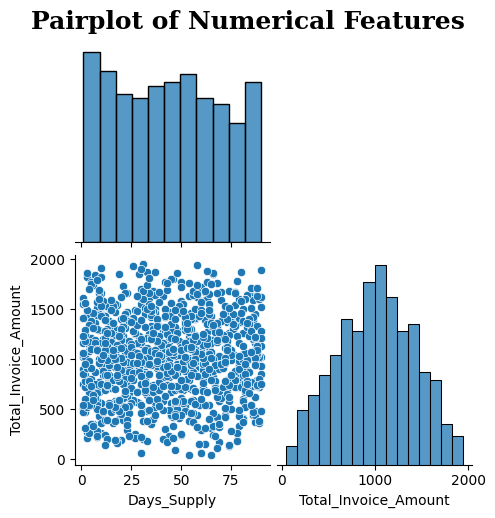

In [16]:
# Pairplot for numerical features to visualize pairwise relationships
sns.pairplot(dta, palette="Blues", corner=True)
plt.suptitle('Pairplot of Numerical Features', y=1.02, fontsize=18, fontweight='bold', fontfamily='serif')
plt.show()

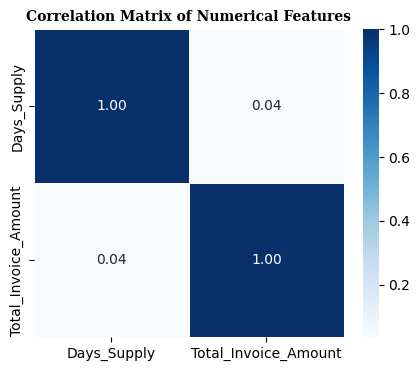

In [17]:
# Correlation Matrix Heatmap
selected_features =[
    'Days_Supply',
    'Total_Invoice_Amount']
corr_matrix = dta[selected_features].corr()  # Compute the correlation matrix

plt.figure(figsize=(5, 4))

sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features', fontsize=10, fontweight='bold', fontfamily='serif')
plt.show()

Usually after some data preprocessing steps we perform pairplot (with the hue parameter) and heatmap (correlation) together to explore the relationship (dependent vs independent variables), identify trends/outliers/clusters/potential correlation, as well as relevant features for model building. This is the 2nd correlation analysis after the 1st attempt on the raw data but more focused on the response variable and possible predictive features. There is no strong evidence to support `Days_Supply` as a predictor for `Total_Invoice_Amount` which is unexpected. 

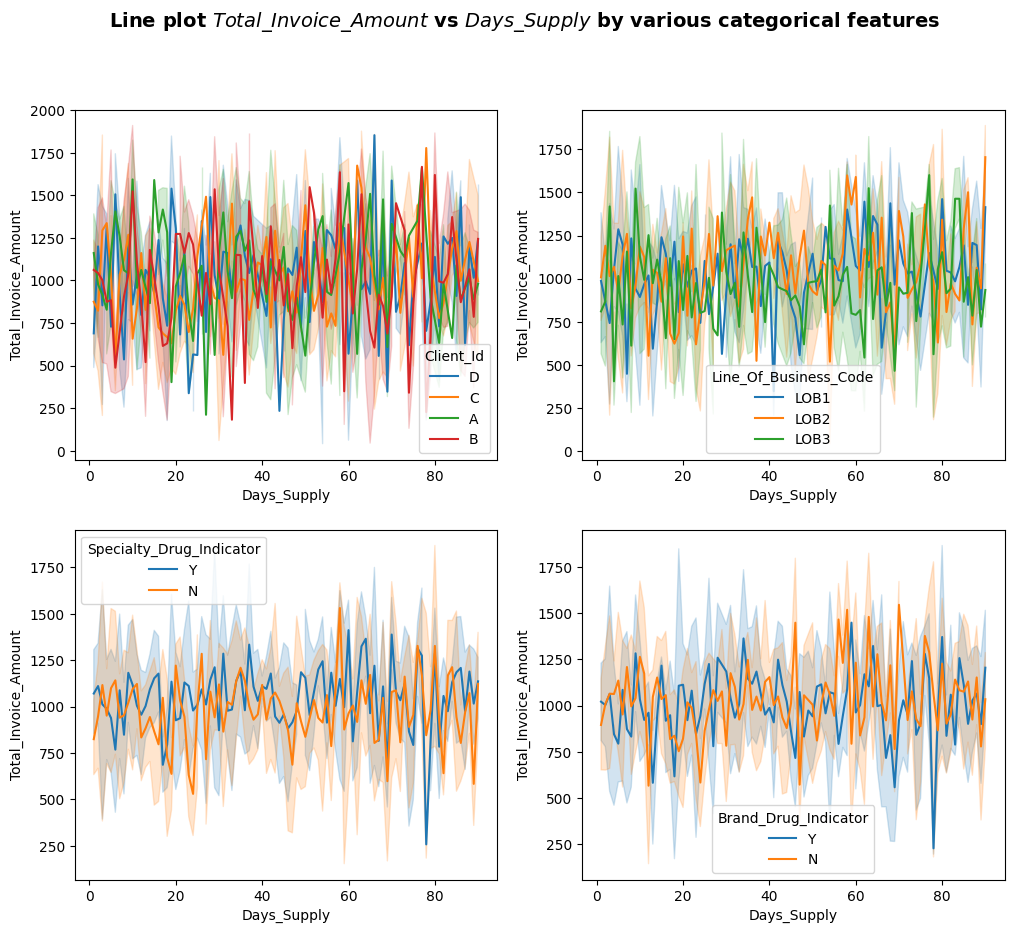

In [18]:
# Explore the relationship (trends and/or patterns) between day of supply and total invoice amount for different subset of data by the selected categorical features.
 
categorical_features = [
    'Client_Id',
    'Line_Of_Business_Code', 
    'Specialty_Drug_Indicator',
    'Brand_Drug_Indicator'
    ]


fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

fig.suptitle("Line plot $\\mathit{Total\\_Invoice\\_Amount}$ vs $\\mathit{Days\\_Supply}$ by various categorical features",
             fontsize=14, fontweight='bold')
for i, feature in enumerate(categorical_features):
    # lineplot instead of relplot (figure level function, no ax)
    sns.lineplot(data=dta, 
                 x='Days_Supply',
                 y='Total_Invoice_Amount',
                 hue=feature, ax=axs[i],
                 )
# Adjust and show
plt.show()

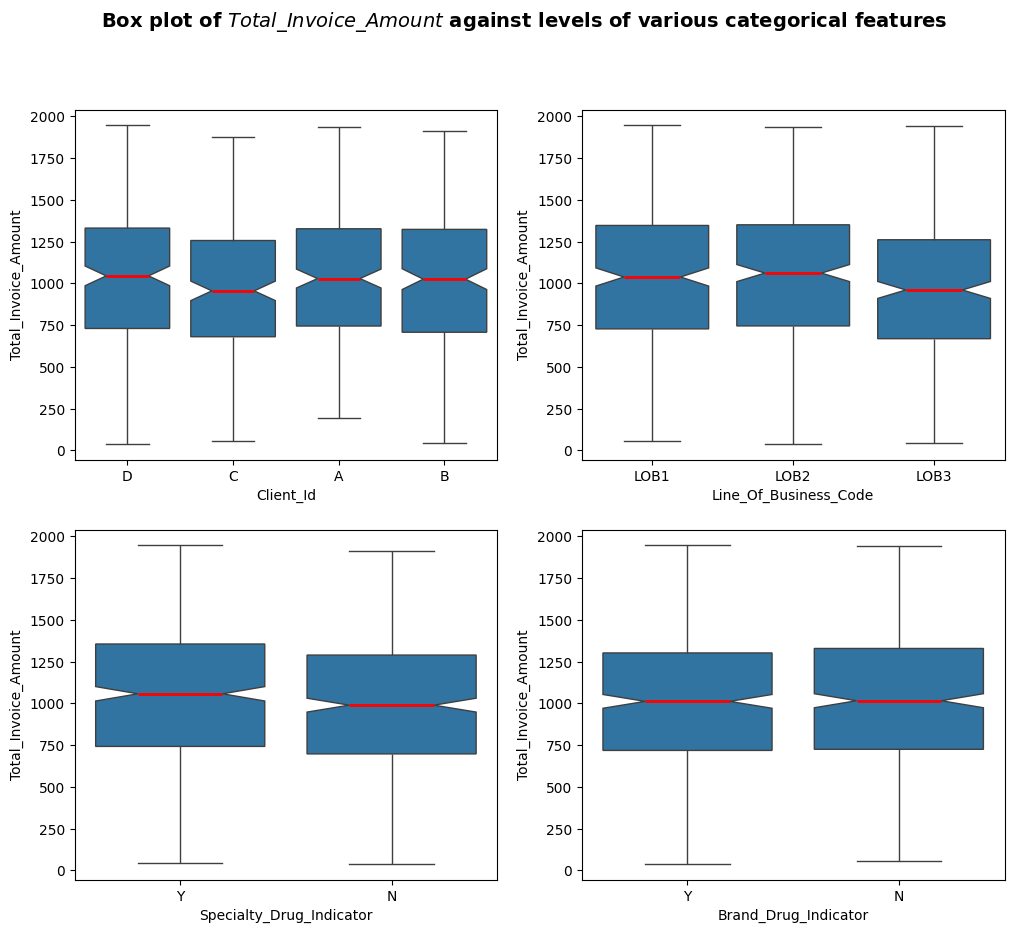

In [18]:
#  Box plots to explore the distribution of quantitative data (Total_Invoice_Amount) across levels of the selected categorical variables.

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

fig.suptitle("Box plot of $\\mathit{Total\\_Invoice\\_Amount}$ against levels of various categorical features",
             fontsize=14, fontweight='bold')
for i, feature in enumerate(categorical_features):
    ax=axs[i]
    # boxplot instead of catplot (figure level function, no ax)
    sns.boxplot(data=dta, 
                x=feature,
                y='Total_Invoice_Amount',
                notch=True,
                medianprops={"color": "r", "linewidth": 2},
                ax=ax
                )

# Adjust and show
plt.show()

Summaries from the above analysis on the numeric features, categorical features and their simple interactions in response to the target dependent variable: </br>
- There is no strong evidence to support `Days_Supply` as a predictor for `Total_Invoice_Amount` which is unexpected. 
- Line plots between `Days_Supply` and `Total_Invoice_Amount` for different subsets of data by the selected categorical features do not reveal any clear interaction pattern.
- There is no clear trend or pattern between the dependent variable `Total_Invoice_Amount` and any of the selected categorical features in these boxplots. No outliers (local) are detected across levels of the selected categorical variables.

### Demo - Linear regression
As summarized in the above data and feature analysis section, we are not expecting any better performing model build upon this synthetic data with decent evaluation metrics. This section is for demonstration purposes only. In general, a baseline model is built first followed by (iterative) hyperparameter tuning, feature engineering, feature/model selection, cross validation, etc. Once certain metrics level is met, the model(s) maybe deployed in a production envnironment where the focus will be switched to model monitoring (shift, drift) and maintenance. </br>
To keep it simple in this demo, one numeric (`Days_Supply`) and one categorical varaible (`Brand_Drug_Indicator`) will be included into the feature variables to model the response variable, `Total_Invoice_Amount`.

In [19]:
# Make NumPy printouts easier to read.
np.set_printoptions(precision=4, suppress=True)

numeric_features = ['Days_Supply']

categorical_features = [
    'Client_Id',
    'Line_Of_Business_Code', 
    'Specialty_Drug_Indicator',
    'Brand_Drug_Indicator'
    ]

target = ['Total_Invoice_Amount']

# Separate features (X) and target variable (y)
X = dta[numeric_features + categorical_features]
y = dta[target]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Sklearn is a popular choice for Linear Regression. It has a Pipeline API that can chain almost all data preprocessing steps together with model approach into one object. 

In [20]:
X = dta[numeric_features + categorical_features]
y = dta['Total_Invoice_Amount']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# preprocessing pipelines for both numeric and categorical data which multiple data processing options to choose including scaling, encoding, imputation, selection, ... here only one step each is selected.
numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ]
)
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ]
)

# Create the transformer and associate each of these preprocessors with their respective columns
preprocessor = ColumnTransformer(
     transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# chain the combine data processor and regressor (or classifier)
model_pipe = Pipeline(
    steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())]
)

# Fit a model
model_pipe.fit(X_train, y_train)

# output the two main performance metrics for this baseline model
# The coefficient of determination of the prediction (R-squared) from linear regression
print(f"R-squared:  {round(model_pipe.score(X_test, y_test), 3)}")
# Root mean squared error (RMSE) regression loss.
print(f"RMSE:  {round(root_mean_squared_error(y_test, model_pipe.predict(X_test)), 4)}")


R-squared:  -0.011
RMSE:  421.4367


The model coefficient of determination, or R-squared essentially shows what proportion of the variance in the dependent variable is explained by the independent variable(s) in the model. A higher value signifies a better fit, with a perfect fit being represented by a value of 1. The R-squared is negative here which indicates the model fits the data really poorly. This outcome agrees with the data analysis results (pairplot, correlation test etc.) that no relationship exists between the response and any of the selected predictor variables.   

In [21]:
# Display the pipeline
set_config(display='diagram')
display(model_pipe)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Days_Supply']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Client_Id',
                                                   'Line_Of_Business_Code',
                                                   'Specialty_Drug_Indicator',
                                                   'Brand_Drug_Indicator'])])),
                ('regressor', LinearRegression())])

In [22]:
# Model input features, coefficients, and intercept
print(f"Pipeline input fearures: {model_pipe.feature_names_in_}\n"
      f"Model input features: {model_pipe[:-1].get_feature_names_out()}\n"
      f"Feature coefficent: {model_pipe._final_estimator.coef_}\n"
      f"Intercept:{model_pipe._final_estimator.intercept_}"
      )
# or mmodel_pipe.named_steps['regressor'].coef_

Pipeline input fearures: ['Days_Supply' 'Client_Id' 'Line_Of_Business_Code'
 'Specialty_Drug_Indicator' 'Brand_Drug_Indicator']
Model input features: ['num__Days_Supply' 'cat__Client_Id_A' 'cat__Client_Id_B'
 'cat__Client_Id_C' 'cat__Client_Id_D' 'cat__Line_Of_Business_Code_LOB1'
 'cat__Line_Of_Business_Code_LOB2' 'cat__Line_Of_Business_Code_LOB3'
 'cat__Specialty_Drug_Indicator_N' 'cat__Specialty_Drug_Indicator_Y'
 'cat__Brand_Drug_Indicator_N' 'cat__Brand_Drug_Indicator_Y']
Feature coefficent: [ 1.5218e+01 -1.3584e+14 -1.3584e+14 -1.3584e+14 -1.3584e+14 -2.5551e+14
 -2.5551e+14 -2.5551e+14 -5.9969e+15 -5.9969e+15  3.2671e+14  3.2671e+14]
Intercept:6061529256510151.0


Linear Regression using `statsmodels.api` outputs a nice summary with statistical significance, AIC/BIC, etc. These indicators especialy p-values should not be applied as feature selection creteria for model iterative improvement.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = pd.get_dummies(data=X_train, drop_first=True).astype(float)
X_train_Sm = sm.add_constant(X_train)
ls=sm.OLS(y_train,X_train_Sm).fit()
print(ls.summary())

                             OLS Regression Results                             
Dep. Variable:     Total_Invoice_Amount   R-squared:                       0.018
Model:                              OLS   Adj. R-squared:                  0.008
Method:                   Least Squares   F-statistic:                     1.827
Date:                  Thu, 07 Nov 2024   Prob (F-statistic):             0.0688
Time:                          12:10:15   Log-Likelihood:                -5947.9
No. Observations:                   800   AIC:                         1.191e+04
Df Residuals:                       791   BIC:                         1.196e+04
Df Model:                             8                                         
Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------


Summary from the basic Linear regression model:
- Linear Regression (Sklearn) model with four categorical features and one numerical feature returns a negative $R^2$ from the test dataset, indicating the model dose an awful fitting on the data. The $R^2$ by OLS (statsmodels) also close to zero.
- When working on a real world data, model optimization iterations should be performed until certain metrics are achieved, which include regularization/penalization (parameter tuning), feature engineering, feature transformation (or Generalized linear model), model complexity reduction (less features), and/or test with additional terms (polynomial terms, interaction terms).
- Try different models (families) and/or ensemble regression algorithms, for example GradientBoosting, XGBoost.
- Data quality is the most important aspect of training ML models. There were no patterns or rules revealed from this synthetic data so this Linear regression section was called a Demo. When working on a real project with dataset like this, it is not suggested to move on to the model build effort at the first place but instead put more effort to improve the data quality.  

### Supplementary Analysis

##### Plot to look for Seasonal Pattern

<Axes: xlabel='Date_Of_Service', ylabel='Total_Invoice_Amount'>

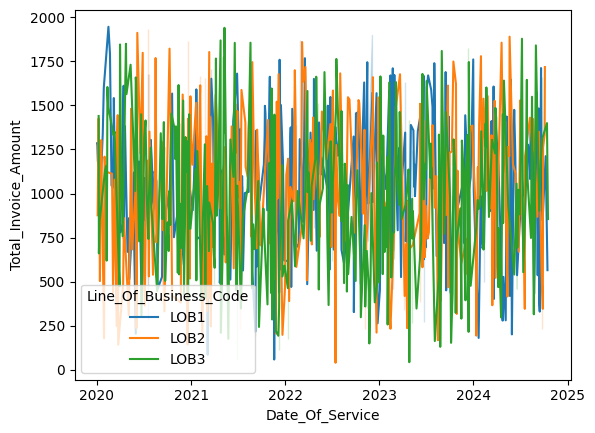

In [ ]:
# Plot the responses over time 
sns.lineplot(data=sp_claim,
             x="Date_Of_Service",
             y="Total_Invoice_Amount",
             hue="Line_Of_Business_Code",
             #style="Specialty_Drug_Indicator",
             )

Note: No seasonal pattern can be revealed from this quick plot but in depth analysis may be necessary for real world data. 

##### Feature importance predictor evaluation from XGBoost by SHAP

/mnt/e/zhaohuiwang/dev/analytics-playground/analytics-playground/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


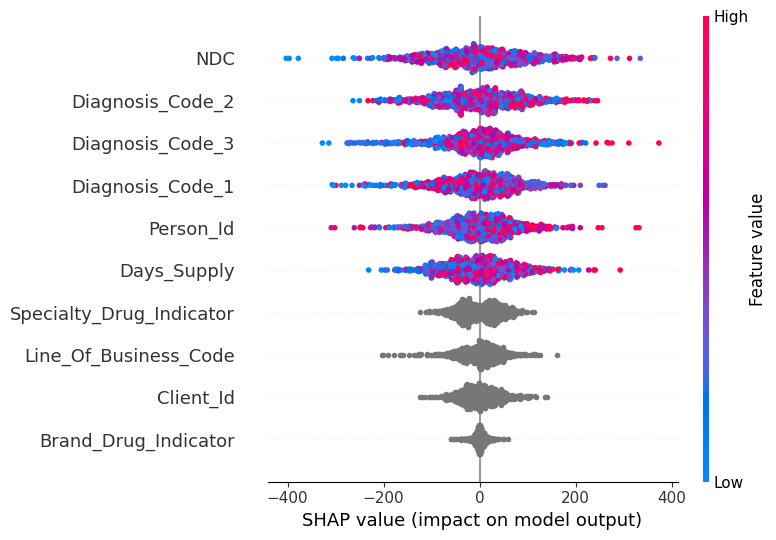

In [ ]:
# Quickly feature importance analysis using EXBoost and SHAP, skipping the hyperparameter tuning step   
from xgboost import XGBRegressor
import shap

categorical_features = [
    'Client_Id',
    'Line_Of_Business_Code', 
    'Specialty_Drug_Indicator',
    'Brand_Drug_Indicator'
    ]

X = sp_claim.drop(columns=['Total_Invoice_Amount', 'Date_Of_Service', 'Claim_Fact_Id'])
y = sp_claim['Total_Invoice_Amount']
X[categorical_features] = X[categorical_features].astype("category")

model = XGBRegressor(enable_categorical=True).fit(X, y)

shap_values = shap.TreeExplainer(model).shap_values(X)

shap.summary_plot(shap_values, X)

Note: Beeswarm plots are a more complex and information-rich display of SHAP values that reveal not just the relative importance of features, but their actual relationships with the predicted outcome. The color bar to the right of the plot corresponds to the raw feature values. The SHAP value ruler is at the bottom. Each dot on the plot represents an instance/row data point correspondin to the feature name on the left. We should be looking for the distribution of points or cluster of similar values (by color) along the SHAP value ruler. There is no pattern at across the features and this analysis confirms there is no predictive feature for `Total_Invoice_Amount` target variable in this synthetic dataset. 

In [1]:
!jupyter nbconvert --to html prime_exercise.ipynb

[NbConvertApp] Converting notebook prime_exercise.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 9 image(s).
[NbConvertApp] Writing 1680923 bytes to prime_exercise.html
